<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork820-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Tackle Imbalanced Data Challenge**


Estimated time needed: **60** minutes


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions: 


| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      | 
| _Predicting Customer Churn_ | ~5 : 1      | 
| _Tumor Type Estimation_ | ~2 : 1     | 
| _Predicting Job Change_ | ~10 : 1      | 


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:
- Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
- Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


* Identify typical patterns of imbalanced data challenges
* Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
* Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
* Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


In [18]:
import pandas as pd
import numpy as np
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter

Grid Search CV Methods.

In [10]:
RANDOM_STATE = 123

In [11]:
def grid_search_lr(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'class_weight': [
            {0: 0.05, 1: 0.95},
            {0: 0.1, 1: 0.9},
            {0: 0.2, 1: 0.8}
        ]
    }
    lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
    grid_search = GridSearchCV(
        estimator=lr_model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=True
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def grid_search_rf(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 50, 100],
        'min_samples_split': [2, 5],
        'class_weight': [
            {0: 0.1, 1: 0.9},
            {0: 0.2, 1: 0.8},
            {0: 0.3, 1: 0.7}
        ]
    }
    rf_model = RandomForestClassifier(random_state=random_state)
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=True
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [12]:
def split_data(df, y_column, random_state=RANDOM_STATE):
    X = df.drop(y_column, axis=1)
    y = df[y_column]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

## Scenario: Credit Card Fraud Detection

Let's start with a credit card fraud detection scenario.
The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.


In [4]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [5]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


In [6]:
Y_COLUMN = 'Class'

In [7]:
credit_df[Y_COLUMN].value_counts(normalize=True)

Class
0    0.999001
1    0.000999
Name: proportion, dtype: float64

<Axes: xlabel='Class'>

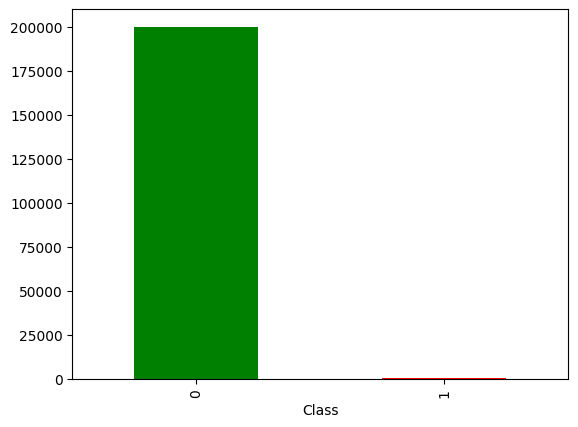

In [8]:
credit_df[Y_COLUMN].value_counts().plot.bar(color=['green', 'red'])

As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset.

In [9]:
X_train, X_test, y_train, y_test = split_data(credit_df, Y_COLUMN)

In [15]:
model = LogisticRegression(random_state=RANDOM_STATE,
                           max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [16]:
accuracy_score(y_test, preds)

0.9992757242757243

OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.


### More Robust Evaluation Metrics


Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:


- `Precision`: the percentage of accurately predicted positive instances

- `Recall`: the percentage of successfully recognized positive instances

- `Fscore`: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the `beta`  parameter, the default value is 1 so the most common F-beta is F1 score


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/images/evaluation_metrics.png" width="720" alt="evaluation metrics">
</center>


In addition, the plot of True positive rate and false positive ratio under different thresholds, known as Receiver operating characteristic `ROC` and its associated Area Under the Curve `AUC` are also reliable metrics.


In [28]:
def print_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fbeta, support = precision_recall_fscore_support(y_true, y_pred, beta=5, pos_label=1, average='binary')
    auc = roc_auc_score(y_test, preds)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {fbeta:.2f}")
    print(f"AUC is: {auc:.2f}")

In [21]:
print_classification_metrics(y_test, preds)

Accuracy is: 1.00
Precision is: 0.72
Recall is: 0.45
Fscore is: 0.46
AUC is: 0.72


For many machine learning tasks on imbalanced datasets, like this credit card fraud detection, we normally care more about recall than precision. As a baseline, we want the model to be able to find all frauds and we would allow the model to make false-positive errors because the cost of false positives is usually not very high (maybe just costs a false notification email or phone call to confirm with customers). On the other hand, failing to recognize positive examples (such as fraud or a deadly disease) can be life-threatening 

As such, our priority is to improve the model's recall, then we will also want to keep precision as high as possible. 


### Synthetic Minority Oversampling Technique (SMOTE)


SMOTE first creates many pairs or small clusters with two or more similar instances, the measure by instance distance such as Euclidean distance.
Then, within the boundary of each pair or cluster, SMOTE uniformly permutes features value, one feature at a time, to populate a collection of similar synthesized instances within each pair or cluster.

As a result, SMOTE creates a class-balanced synthetic dataset without adding duplicated instances with minority labels. 


The `imblearn` package provides us with many effective samplers including `SMOTE`, `RandomOverSampler`, and `RandomUnderSampler`. Let's use its `SMOTE` class to define a SMOTE sampler first


In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [24]:
smote_sampler = SMOTE(random_state=RANDOM_STATE)

In [25]:
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

<Axes: xlabel='Class'>

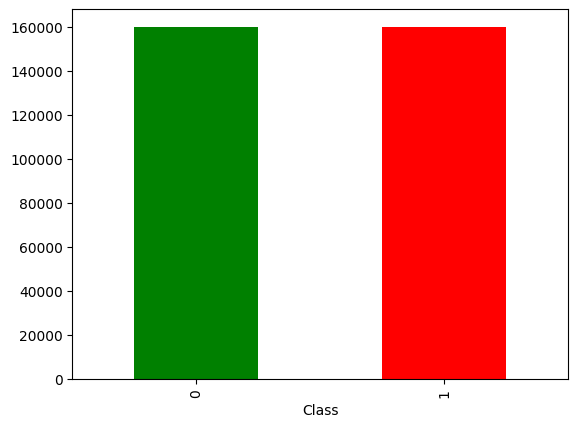

In [26]:
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [27]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test)